In [53]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import tensorflow as tf
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, classification_report
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.layers import (LSTM, Dense, Concatenate, Attention, Dropout, Softmax,
                                     Input, Flatten, Activation, Bidirectional, Permute, multiply, 
                                     ConvLSTM2D, MaxPooling3D, TimeDistributed, Conv2D, MaxPooling2D)

from scipy import stats

os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"
tf.get_logger().setLevel("ERROR")
tf.autograph.set_verbosity(1)

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

keypts

In [55]:

mp_pose = mp.solutions.pose

mp_drawing = mp.solutions.drawing_utils

In [56]:
def mediapipe_detection(image, model):
    """
    This function detects human pose estimation keypoints from webcam footage
    
    """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    image.flags.writeable = False                  
    results = model.process(image)                
    image.flags.writeable = True                  
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
    return image, results

In [57]:
def draw_landmarks(image, results):
    """
    This function draws keypoints and landmarks detected by the human pose estimation model
    
    """
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=2), 
                                mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2) 
                                 )

In [58]:
cap = cv2.VideoCapture(3) 
HEIGHT = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) 
WIDTH = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) 
FPS = int(cap.get(cv2.CAP_PROP_FPS)) 
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():

        ret, frame = cap.read()
      
        image, results = mediapipe_detection(frame, pose)
        
        try:
            landmarks = results.pose_landmarks.landmark
        except:
            pass
        
        draw_landmarks(image, results)               
        
        cv2.imshow('OpenCV Feed', image)
        
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

get keypts

In [59]:

pose = []
for res in results.pose_landmarks.landmark:
    test = np.array([res.x, res.y, res.z, res.visibility])
    pose.append(test)

In [60]:
# 33 landmarks with 4 values (x, y, z, visibility)
num_landmarks = len(landmarks)
num_values = len(test)
num_input_values = num_landmarks*num_values

In [61]:

pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)

In [63]:
def extract_keypoints(results):
    """
    Processes and organizes the keypoints detected from the pose estimation model 
    to be used as inputs for the exercise decoder models
    
    """
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    return pose

In [64]:

DATA_PATH = os.path.join(os. getcwd(),'data') 
print(DATA_PATH)

if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

actions = np.array(['curl', 'press', 'squat'])
num_classes = len(actions)

no_sequences = 50

sequence_length = FPS*1

start_folder = 101

/home/cyclops/Desktop/datahon/streamlitfrommain/data


In [65]:

for action in actions:     
    for sequence in range(start_folder,no_sequences+start_folder):
        try: 
            os.makedirs(os.path.join(DATA_PATH, action, str(sequence)))  
        except:
            pass

In [66]:

colors = [(0,0,139), (199,21,133), (16,117,245)]

In [69]:
cap = cv2.VideoCapture(3)
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    for idx, action in enumerate(actions):
        for sequence in range(start_folder, start_folder+no_sequences):
            for frame_num in range(sequence_length):
                ret, frame = cap.read()
                image, results = mediapipe_detection(frame, pose)
                try:
                    landmarks = results.pose_landmarks.landmark
                except:
                    pass
                draw_landmarks(image, results) 
                if frame_num == 0:
                    cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting {} Video # {}'.format(action, sequence), (15,30), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 8, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting {} Video # {}'.format(action, sequence), (15,30), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, colors[idx], 4, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)
                    cv2.waitKey(500)
                else: 
                    cv2.putText(image, 'Collecting {} Video # {}'.format(action, sequence), (15,30), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 8, cv2.LINE_AA)
                    cv2.putText(image, 'Collecting {} Video # {}'.format(action, sequence), (15,30), 
                            cv2.FONT_HERSHEY_SIMPLEX, 1, colors[idx], 4, cv2.LINE_AA)
                    cv2.imshow('OpenCV Feed', image)
                keypoints = extract_keypoints(results)
                npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                np.save(npy_path, keypoints)
                if cv2.waitKey(10) & 0xFF == ord('q'):
                    break
    cap.release()
    cv2.destroyAllWindows()

In [70]:
cap.release()
cv2.destroyAllWindows()

In [71]:
label_map = {label:num for num, label in enumerate(actions)}

In [72]:

sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):         
            # LSTM input data
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)  
            
        sequences.append(window)
        labels.append(label_map[action])

In [73]:

X = np.array(sequences)
y = to_categorical(labels).astype(int)
print(X.shape, y.shape)

(150, 30, 132) (150, 3)


In [74]:
# Split into training, validation, and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=1)
print(X_train.shape, y_train.shape)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=15/90, random_state=2)

(135, 30, 132) (135, 3)


build neural

In [83]:

es_callback = EarlyStopping(monitor='val_loss', min_delta=5e-4, patience=10, verbose=0, mode='min')
lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=0, mode='min')
chkpt_callback = ModelCheckpoint(filepath=DATA_PATH, monitor='val_loss', verbose=0, save_best_only=True, 
                                 save_weights_only=False, mode='min', save_freq=1)

# Optimizer
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)

batch_size = 32
max_epochs = 500

lstm model 
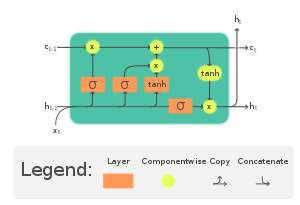

In [84]:

NAME = f"ExerciseRecognition-LSTM-{int(time.time())}"
log_dir = os.path.join(os.getcwd(), 'logs', NAME,'')
tb_callback = TensorBoard(log_dir=log_dir)

callbacks = [tb_callback, es_callback, lr_callback, chkpt_callback]

In [85]:
lstm = Sequential()
lstm.add(LSTM(128, return_sequences=True, activation='relu', input_shape=(sequence_length, num_input_values)))
lstm.add(LSTM(256, return_sequences=True, activation='relu'))
lstm.add(LSTM(128, return_sequences=False, activation='relu'))
lstm.add(Dense(128, activation='relu'))
lstm.add(Dense(64, activation='relu'))
lstm.add(Dense(actions.shape[0], activation='softmax'))
print(lstm.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 30, 128)           133632    
                                                                 
 lstm_9 (LSTM)               (None, 30, 256)           394240    
                                                                 
 lstm_10 (LSTM)              (None, 128)               197120    
                                                                 
 dense_12 (Dense)            (None, 128)               16512     
                                                                 
 dense_13 (Dense)            (None, 64)                8256      
                                                                 
 dense_14 (Dense)            (None, 3)                 195       
                                                                 
Total params: 749955 (2.86 MB)
Trainable params: 74995

In [86]:
lstm.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
lstm.fit(X_train, y_train, batch_size=batch_size, epochs=max_epochs, validation_data=(X_val, y_val), callbacks=callbacks)

Epoch 1/500
4/4 [==============================] - 5s 255ms/step - loss: 268160.9688 - categorical_accuracy: 0.3839 - val_loss: 615036.9375 - val_categorical_accuracy: 0.2609 - lr: 0.0100
Epoch 2/500
4/4 [==============================] - 0s 77ms/step - loss: 312474.5938 - categorical_accuracy: 0.2857 - val_loss: 1689.8573 - val_categorical_accuracy: 0.3478 - lr: 0.0100
Epoch 3/500
4/4 [==============================] - 0s 65ms/step - loss: 2183.4915 - categorical_accuracy: 0.3571 - val_loss: 8386.9941 - val_categorical_accuracy: 0.2609 - lr: 0.0100
Epoch 4/500
4/4 [==============================] - 0s 75ms/step - loss: 3979.8438 - categorical_accuracy: 0.3661 - val_loss: 2221.4890 - val_categorical_accuracy: 0.3478 - lr: 0.0100
Epoch 5/500
4/4 [==============================] - 0s 70ms/step - loss: 1001.1968 - categorical_accuracy: 0.3304 - val_loss: 149.4812 - val_categorical_accuracy: 0.3043 - lr: 0.0100
Epoch 6/500
4/4 [==============================] - 0s 62ms/step - loss: 313.488

add attention
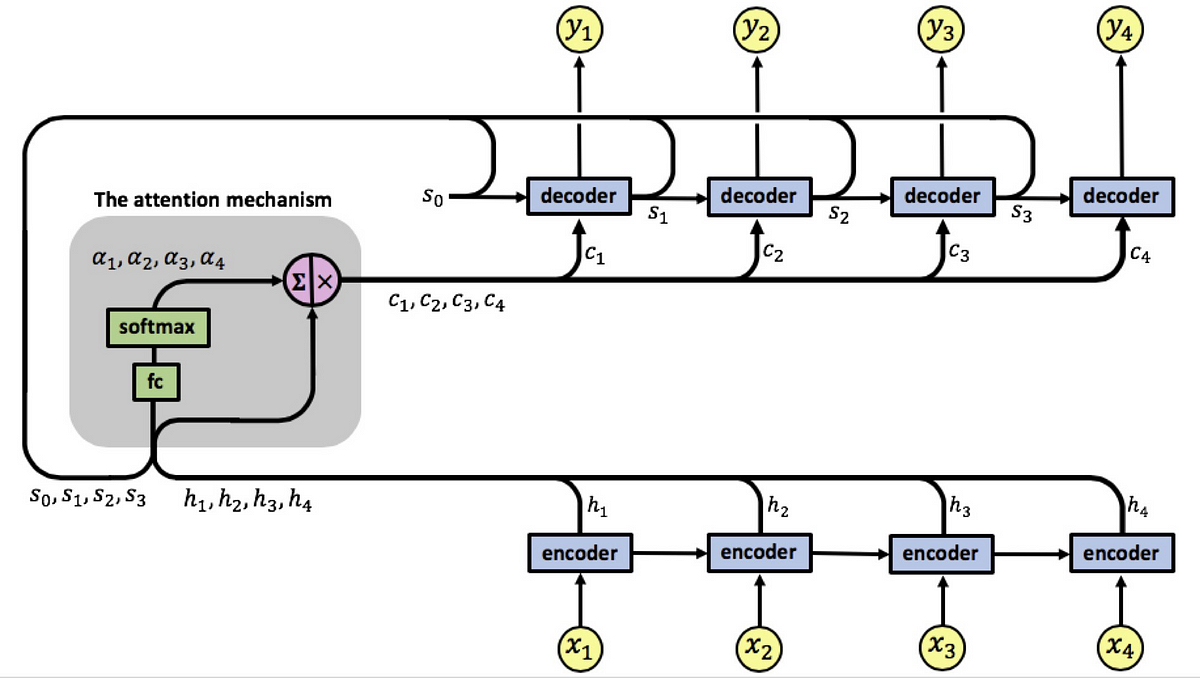

In [87]:

NAME = f"ExerciseRecognition-AttnLSTM-{int(time.time())}"
log_dir = os.path.join(os.getcwd(), 'logs', NAME,'')
tb_callback = TensorBoard(log_dir=log_dir)

callbacks = [tb_callback, es_callback, lr_callback, chkpt_callback]

In [88]:
def attention_block(inputs, time_steps):
    """
    Attention layer for deep neural network
    
    """
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax')(a)
    
    a_probs = Permute((2, 1), name='attention_vec')(a)
    
    # Luong's multiplicative score
    output_attention_mul = multiply([inputs, a_probs], name='attention_mul') 
    
    return output_attention_mul

In [89]:
HIDDEN_UNITS = 256

# Input
inputs = Input(shape=(sequence_length, num_input_values))

# Bi-LSTM
lstm_out = Bidirectional(LSTM(HIDDEN_UNITS, return_sequences=True))(inputs)

# Attention
attention_mul = attention_block(lstm_out, sequence_length)
attention_mul = Flatten()(attention_mul)

# Fully Connected Layer
x = Dense(2*HIDDEN_UNITS, activation='relu')(attention_mul)
x = Dropout(0.5)(x)

# Output
x = Dense(actions.shape[0], activation='softmax')(x)

# Bring it all together
AttnLSTM = Model(inputs=[inputs], outputs=x)
print(AttnLSTM.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 30, 132)]            0         []                            
                                                                                                  
 bidirectional_2 (Bidirecti  (None, 30, 512)              796672    ['input_3[0][0]']             
 onal)                                                                                            
                                                                                                  
 permute_2 (Permute)         (None, 512, 30)              0         ['bidirectional_2[0][0]']     
                                                                                                  
 dense_15 (Dense)            (None, 512, 30)              930       ['permute_2[0][0]']     

In [90]:
AttnLSTM.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
AttnLSTM.fit(X_train, y_train, batch_size=batch_size, epochs=max_epochs, validation_data=(X_val, y_val), callbacks=callbacks)

Epoch 1/500
4/4 [==============================] - 6s 396ms/step - loss: 1.0991 - categorical_accuracy: 0.3036 - val_loss: 1.0575 - val_categorical_accuracy: 0.6087 - lr: 4.0000e-04
Epoch 2/500
4/4 [==============================] - 0s 88ms/step - loss: 1.0062 - categorical_accuracy: 0.6250 - val_loss: 0.9377 - val_categorical_accuracy: 0.4783 - lr: 4.0000e-04
Epoch 3/500
4/4 [==============================] - 0s 101ms/step - loss: 0.7368 - categorical_accuracy: 0.7946 - val_loss: 0.6474 - val_categorical_accuracy: 0.7391 - lr: 4.0000e-04
Epoch 4/500
4/4 [==============================] - 0s 87ms/step - loss: 0.3568 - categorical_accuracy: 0.9107 - val_loss: 0.2985 - val_categorical_accuracy: 0.9130 - lr: 4.0000e-04
Epoch 5/500
4/4 [==============================] - 0s 94ms/step - loss: 0.1302 - categorical_accuracy: 0.9821 - val_loss: 0.1709 - val_categorical_accuracy: 0.9130 - lr: 4.0000e-04
Epoch 6/500
4/4 [==============================] - 0s 87ms/step - loss: 0.0953 - categorical_

In [91]:
models = {
    'LSTM': lstm, 
    'LSTM_Attention_128HUs': AttnLSTM, 
}

In [92]:
for model_name, model in models.items():
    save_dir = os.path.join(os.getcwd(), f"{model_name}.h5")
    model.save(save_dir)

/home/cyclops/Desktop/datahon/env/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [93]:
#google says do this
for model_name, model in models.items():
    load_dir = os.path.join(os.getcwd(), f"{model_name}.h5")
    model.load_weights(load_dir)

In [94]:
for model in models.values():
    res = model.predict(X_test, verbose=0)   

confusion matrix 
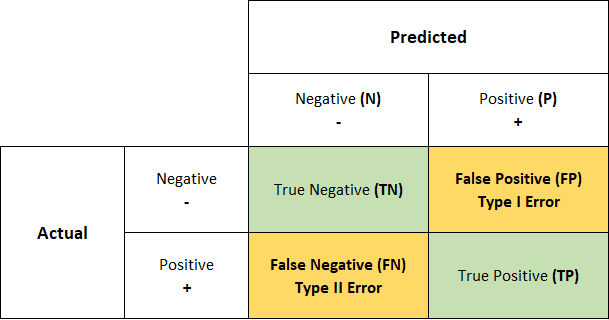

In [95]:
eval_results = {}
eval_results['confusion matrix'] = None
eval_results['accuracy'] = None
eval_results['precision'] = None
eval_results['recall'] = None
eval_results['f1 score'] = None

confusion_matrices = {}
classification_accuracies = {}   
precisions = {}
recalls = {}
f1_scores = {} 

In [96]:
for model_name, model in models.items():
    yhat = model.predict(X_test, verbose=0)
    
    
    ytrue = np.argmax(y_test, axis=1).tolist()
    yhat = np.argmax(yhat, axis=1).tolist()
    
   
    confusion_matrices[model_name] = multilabel_confusion_matrix(ytrue, yhat)
    print(f"{model_name} confusion matrix: {os.linesep}{confusion_matrices[model_name]}")


eval_results['confusion matrix'] = confusion_matrices

LSTM confusion matrix: 
[[[10  0]
  [ 5  0]]

 [[ 9  0]
  [ 6  0]]

 [[ 0 11]
  [ 0  4]]]
LSTM_Attention_128HUs confusion matrix: 
[[[10  0]
  [ 0  5]]

 [[ 9  0]
  [ 0  6]]

 [[11  0]
  [ 0  4]]]


accuracy


In [97]:
for model_name, model in models.items():
    yhat = model.predict(X_test, verbose=0)
    
   
    ytrue = np.argmax(y_test, axis=1).tolist()
    yhat = np.argmax(yhat, axis=1).tolist()
    
   
    classification_accuracies[model_name] = accuracy_score(ytrue, yhat)    
    print(f"{model_name} classification accuracy = {round(classification_accuracies[model_name]*100,3)}%")


eval_results['accuracy'] = classification_accuracies

LSTM classification accuracy = 26.667%
LSTM_Attention_128HUs classification accuracy = 100.0%


In [98]:
for model_name, model in models.items():
    yhat = model.predict(X_test, verbose=0)
    
   
    ytrue = np.argmax(y_test, axis=1).tolist()
    yhat = np.argmax(yhat, axis=1).tolist()

    
    report = classification_report(ytrue, yhat, target_names=actions, output_dict=True)
    
    precisions[model_name] = report['weighted avg']['precision']
    recalls[model_name] = report['weighted avg']['recall']
    f1_scores[model_name] = report['weighted avg']['f1-score'] 
   
    print(f"{model_name} weighted average precision = {round(precisions[model_name],3)}")
    print(f"{model_name} weighted average recall = {round(recalls[model_name],3)}")
    print(f"{model_name} weighted average f1-score = {round(f1_scores[model_name],3)}\n")


eval_results['precision'] = precisions
eval_results['recall'] = recalls
eval_results['f1 score'] = f1_scores

LSTM weighted average precision = 0.071
LSTM weighted average recall = 0.267
LSTM weighted average f1-score = 0.112

LSTM_Attention_128HUs weighted average precision = 1.0
LSTM_Attention_128HUs weighted average recall = 1.0
LSTM_Attention_128HUs weighted average f1-score = 1.0



/home/cyclops/Desktop/datahon/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cyclops/Desktop/datahon/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/cyclops/Desktop/datahon/env/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(resu

real time

In [99]:
model = AttnLSTM
model_name = 'AttnLSTM'

In [100]:
def calculate_angle(a,b,c):
    """
    Computes 3D joint angle inferred by 3 keypoints and their relative positions to one another
    
    """
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
        
    return angle 

In [101]:
def get_coordinates(landmarks, mp_pose, side, joint):
    """
    Retrieves x and y coordinates of a particular keypoint from the pose estimation model
         
     Args:
         landmarks: processed keypoints from the pose estimation model
         mp_pose: Mediapipe pose estimation model
         side: 'left' or 'right'. Denotes the side of the body of the landmark of interest.
         joint: 'shoulder', 'elbow', 'wrist', 'hip', 'knee', or 'ankle'. Denotes which body joint is associated with the landmark of interest.
    
    """
    coord = getattr(mp_pose.PoseLandmark,side.upper()+"_"+joint.upper())
    x_coord_val = landmarks[coord.value].x
    y_coord_val = landmarks[coord.value].y
    return [x_coord_val, y_coord_val]            

In [102]:
def viz_joint_angle(image, angle, joint):
    """
    Displays the joint angle value near the joint within the image frame
    
    """
    cv2.putText(image, str(int(angle)), 
                   tuple(np.multiply(joint, [640, 480]).astype(int)), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2, cv2.LINE_AA
                        )
    return

In [103]:
def count_reps(image, current_action, landmarks, mp_pose):
    """
    Counts repetitions of each exercise. Global count and stage (i.e., state) variables are updated within this function.
    
    """

    global curl_counter, press_counter, squat_counter, curl_stage, press_stage, squat_stage
    
    if current_action == 'curl':
        # Get coords
        shoulder = get_coordinates(landmarks, mp_pose, 'left', 'shoulder')
        elbow = get_coordinates(landmarks, mp_pose, 'left', 'elbow')
        wrist = get_coordinates(landmarks, mp_pose, 'left', 'wrist')
        
        # calculate elbow angle
        angle = calculate_angle(shoulder, elbow, wrist)
        
        # curl counter logic
        if angle < 30:
            curl_stage = "up" 
        if angle > 140 and curl_stage =='up':
            curl_stage="down"  
            curl_counter +=1
        press_stage = None
        squat_stage = None
            
        # Viz joint angle
        viz_joint_angle(image, angle, elbow)
        
    elif current_action == 'press':
        
        # Get coords
        shoulder = get_coordinates(landmarks, mp_pose, 'left', 'shoulder')
        elbow = get_coordinates(landmarks, mp_pose, 'left', 'elbow')
        wrist = get_coordinates(landmarks, mp_pose, 'left', 'wrist')

        # Calculate elbow angle
        elbow_angle = calculate_angle(shoulder, elbow, wrist)
        
        # Compute distances between joints
        shoulder2elbow_dist = abs(math.dist(shoulder,elbow))
        shoulder2wrist_dist = abs(math.dist(shoulder,wrist))
        
        # Press counter logic
        if (elbow_angle > 130) and (shoulder2elbow_dist < shoulder2wrist_dist):
            press_stage = "up"
        if (elbow_angle < 50) and (shoulder2elbow_dist > shoulder2wrist_dist) and (press_stage =='up'):
            press_stage='down'
            press_counter += 1
        curl_stage = None
        squat_stage = None
            
        # Viz joint angle
        viz_joint_angle(image, elbow_angle, elbow)
        
    elif current_action == 'squat':
        # Get coords
        # left side
        left_shoulder = get_coordinates(landmarks, mp_pose, 'left', 'shoulder')
        left_hip = get_coordinates(landmarks, mp_pose, 'left', 'hip')
        left_knee = get_coordinates(landmarks, mp_pose, 'left', 'knee')
        left_ankle = get_coordinates(landmarks, mp_pose, 'left', 'ankle')
        # right side
        right_shoulder = get_coordinates(landmarks, mp_pose, 'right', 'shoulder')
        right_hip = get_coordinates(landmarks, mp_pose, 'right', 'hip')
        right_knee = get_coordinates(landmarks, mp_pose, 'right', 'knee')
        right_ankle = get_coordinates(landmarks, mp_pose, 'right', 'ankle')
        
        # Calculate knee angles
        left_knee_angle = calculate_angle(left_hip, left_knee, left_ankle)
        right_knee_angle = calculate_angle(right_hip, right_knee, right_ankle)
        
        # Calculate hip angles
        left_hip_angle = calculate_angle(left_shoulder, left_hip, left_knee)
        right_hip_angle = calculate_angle(right_shoulder, right_hip, right_knee)
        
        # Squat counter logic
        thr = 165
        if (left_knee_angle < thr) and (right_knee_angle < thr) and (left_hip_angle < thr) and (right_hip_angle < thr):
            squat_stage = "down"
        if (left_knee_angle > thr) and (right_knee_angle > thr) and (left_hip_angle > thr) and (right_hip_angle > thr) and (squat_stage =='down'):
            squat_stage='up'
            squat_counter += 1
        curl_stage = None
        press_stage = None
            
        # Viz joint angles
        viz_joint_angle(image, left_knee_angle, left_knee)
        viz_joint_angle(image, left_hip_angle, left_hip)
        
    else:
        pass

In [104]:
def prob_viz(res, actions, input_frame, colors):
    """
    This function displays the model prediction probability distribution over the set of exercise classes
    as a horizontal bar graph
    
    """
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):        
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors[num], -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
        
    return output_frame

In [105]:
# 1. New detection variables
sequence = []
predictions = []
res = []
threshold = 0.5 # minimum confidence to classify as an action/exercise
current_action = ''

# Rep counter logic variables
curl_counter = 0
press_counter = 0
squat_counter = 0
curl_stage = None
press_stage = None
squat_stage = None

# Camera object
cap = cv2.VideoCapture(3)

# Video writer object that saves a video of the real time test
fourcc = cv2.VideoWriter_fourcc('M','J','P','G') # video compression format
HEIGHT = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)) # webcam video frame height
WIDTH = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) # webcam video frame width
FPS = int(cap.get(cv2.CAP_PROP_FPS)) # webcam video fram rate 

video_name = os.path.join(os.getcwd(),f"{model_name}_real_time_test.avi")
out = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*"MJPG"), FPS, (WIDTH,HEIGHT))

# Set mediapipe model 
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detection
        image, results = mediapipe_detection(frame, pose)
        
        # Draw landmarks
        draw_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)        
        sequence.append(keypoints)      
        sequence = sequence[-sequence_length:]
              
        if len(sequence) == sequence_length:
            res = model.predict(np.expand_dims(sequence, axis=0), verbose=0)[0]           
            predictions.append(np.argmax(res))
            current_action = actions[np.argmax(res)]
            confidence = np.max(res)
            
        #3. Viz logic
            # Erase current action variable if no probability is above threshold
            if confidence < threshold:
                current_action = ''

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
            # Count reps
            try:
                landmarks = results.pose_landmarks.landmark
                count_reps(
                    image, current_action, landmarks, mp_pose)
            except:
                pass

            # Display graphical information
            cv2.rectangle(image, (0,0), (640, 40), colors[np.argmax(res)], -1)
            cv2.putText(image, 'curl ' + str(curl_counter), (3,30), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            cv2.putText(image, 'press ' + str(press_counter), (240,30), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            cv2.putText(image, 'squat ' + str(squat_counter), (490,30), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
         
        # Show to screen
        cv2.imshow('OpenCV Feed', image)
        
        # Write to video file
        if ret == True:
            out.write(image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    out.release()
    cv2.destroyAllWindows()

In [106]:
cap.release()
out.release()
cv2.destroyAllWindows()